# Wind Load Design

In [16]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import math
import numpy as np
import plotly as pl
import plotly.graph_objects as go
import seaborn
import scienceplots
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import fpdf

from turbulence_regressor import TurbulenceRegressor
# Link for calculation break downs
# https://eurocodeapplied.com/design/en1991/wind-peak-velocity-pressure-ireland-and-uk

In [17]:
plt.style.use(["science", "notebook", "grid"])

class WindRoseDiagram:
    def __init__(self, wind_velocity=None, directional_wind_velocity_profile=None):
        self.wind_velocity = wind_velocity
        self.directional_wind_velocity_profile = directional_wind_velocity_profile
        self.wind_data = []

    def add_data(self, wind_direction, wind_speed):
        """
        Adds wind data to the wind rose.
        :param wind_direction: Wind direction in degrees (0-360)
        :param wind_speed: Wind speed in m/s
        """
        self.wind_data.append((wind_direction, wind_speed))

    def generate_wind_rose(self, num_directions=16, cmap='RdPu'):
        """
        Generates a wind rose diagram.
        :param num_directions: Number of wind direction bins (e.g., 16 for 22.5° bins)
        :param cmap: Colormap for the wind rose
        """
        if self.directional_wind_velocity_profile and self.wind_velocity is not None:
            # Calculate wind speeds from the base wind velocity and the directional profile
            wind_speed = np.array(self.directional_wind_velocity_profile) * self.wind_velocity
            wind_direction = np.linspace(0, 360, num_directions, endpoint=False)
        else:
            # Convert data to numpy arrays for easier manipulation
            wind_direction = np.array([wd for wd, ws in self.wind_data])
            wind_speed = np.array([ws for wd, ws in self.wind_data])

        # Define the direction bins
        direction_bins = np.linspace(0, 360, num_directions + 1)

        # Calculate mean wind speed for each direction bin
        mean_wind_speed = np.zeros(num_directions)
        for i in range(num_directions):
            mask = (wind_direction >= direction_bins[i]) & (wind_direction < direction_bins[i + 1])
            mean_wind_speed[i] = wind_speed[mask].mean() if np.any(mask) else 0

        # Normalize the mean wind speed
        max_speed = mean_wind_speed.max()
        normalized_speed = mean_wind_speed / max_speed if max_speed > 0 else mean_wind_speed

        # Generate the wind rose
        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(15, 15))
        width = 2 * np.pi / num_directions
        colors = plt.get_cmap(cmap)

        for i in range(num_directions):
            if mean_wind_speed[i] > 0:
                ax.bar(
                    direction_bins[i] * np.pi / 180,
                    mean_wind_speed[i],  # Scale bar height by actual wind speed
                    width=width,
                    bottom=0,
                    color=colors(normalized_speed[i]),
                    edgecolor='black',
                    linewidth=0.2,
                    alpha=0.9,
                )

        # Set the labels
        ax.set_theta_direction(-1)
        ax.set_theta_offset(np.pi / 2.0)
        ax.set_xticks(np.linspace(0, 2 * np.pi, num_directions, endpoint=False))
        ax.set_xticklabels(['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW'], fontsize=12, y=-0.1)

        # Set the radial labels (wind speed)
        i_distance_between_rounds = 5
        max_speed_rounded = np.ceil(max_speed / i_distance_between_rounds) * i_distance_between_rounds  # Round up to the nearest 5 for cleaner labels
        ax.set_yticks(np.linspace(0, max_speed_rounded, int(max_speed_rounded / i_distance_between_rounds) + 1))
        ax.set_yticklabels([f'{int(tick)} m/s' for tick in np.linspace(0, max_speed_rounded, int(max_speed_rounded / i_distance_between_rounds) + 1)], fontsize=10, x=-0.5, y = -1.5)

        # Add a colorbar
        sm = cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=max_speed))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', pad=0.10)
        cbar.ax.tick_params(labelsize=10)
        cbar.set_label('Wind Speed [m/s]', fontsize=12, y=0.90)

        plt.title('Wind Velocity Rose Diagram', fontsize=22, y=1.25)
        plt.suptitle(f'Directional Distribution of the Wind Velocity Profile for\nBasic Wind Velocity V_b = {self.wind_velocity} m/s', fontsize=16, y = 1)

        plt.savefig("Wind_Rose_Diagram.png", dpi = 300)
        plt.show()

        
# # Example usage
# wind_velocity = 10  # Example base wind velocity
# directional_wind_velocity_profile = [0.8, 0.7, 0.6, 0.5, 0.4, 0.7, 0.8, 0.9, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3]

# wind_rose = WindRoseDiagram(wind_velocity=wind_velocity, directional_wind_velocity_profile=directional_wind_velocity_profile)
# wind_rose.generate_wind_rose()
        
        
# # # Example usage
# # wind_rose = WindRoseDiagram()
# # wind_rose.add_data(0, 5)
# # wind_rose.add_data(22.5, 5)
# # wind_rose.add_data(45, 3)
# # wind_rose.add_data(67.5, 3)
# # wind_rose.add_data(90, 7)
# # wind_rose.add_data(112.5, 7)
# # wind_rose.add_data(135, 2)
# # wind_rose.add_data(157.5, 3)
# # wind_rose.add_data(180, 7)
# # wind_rose.add_data(202.5, 8)
# # wind_rose.add_data(225, 4)
# # wind_rose.add_data(252.5, 4)
# # wind_rose.add_data(270, 6)
# # wind_rose.add_data(292.5, 13)
# # wind_rose.add_data(315, 10)
# # wind_rose.add_data(337.5, 8)

# # wind_rose.generate_wind_rose()

In [18]:
class PressureRoseDiagram:
    def __init__(self, pressure=None, directional_pressure_profile=None):
        self.pressure = pressure
        self.directional_pressure_profile = directional_pressure_profile
        self.pressure_data = []

    def add_data(self, wind_direction, wind_pressure):
        """
        Adds pressure data to the pressure rose.
        :param wind_direction: Wind direction in degrees (0-360)
        :param wind_pressure: Wind pressure in Pa
        """
        self.pressure_data.append((wind_direction, wind_pressure))

    def generate_pressure_rose(self, num_directions=16, cmap='Blues'):
        """
        Generates a pressure rose diagram.
        :param num_directions: Number of wind direction bins (e.g., 16 for 22.5° bins)
        :param cmap: Colormap for the pressure rose
        """
        if self.directional_pressure_profile and self.pressure is not None:
            # Calculate pressures from the base pressure and the directional profile
            pressure = np.array(self.directional_pressure_profile) * self.pressure
            wind_direction = np.linspace(0, 360, num_directions, endpoint=False)
        else:
            # Convert data to numpy arrays for easier manipulation
            wind_direction = np.array([wd for wd, wp in self.pressure_data])
            pressure = np.array([wp for wd, wp in self.pressure_data])

        # Define the direction bins
        direction_bins = np.linspace(0, 360, num_directions + 1)

        # Calculate mean pressure for each direction bin
        mean_pressure = np.zeros(num_directions)
        for i in range(num_directions):
            mask = (wind_direction >= direction_bins[i]) & (wind_direction < direction_bins[i + 1])
            mean_pressure[i] = pressure[mask].mean() if np.any(mask) else 0

        # Normalize the mean pressure
        max_pressure = mean_pressure.max()
        normalized_pressure = mean_pressure / max_pressure if max_pressure > 0 else mean_pressure

        # Generate the pressure rose
        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(15, 15))
        width = 2 * np.pi / num_directions
        colors = plt.get_cmap(cmap)

        for i in range(num_directions):
            if mean_pressure[i] > 0:
                ax.bar(
                    direction_bins[i] * np.pi / 180,
                    mean_pressure[i],  # Scale bar height by actual pressure
                    width=width,
                    bottom=0,
                    color=colors(normalized_pressure[i]),
                    edgecolor='black',
                    linewidth=0.2,
                    alpha=0.9,
                )

        # Set the labels
        ax.set_theta_direction(-1)
        ax.set_theta_offset(np.pi / 2.0)
        ax.set_xticks(np.linspace(0, 2 * np.pi, num_directions, endpoint=False))
        ax.set_xticklabels(['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW'], fontsize=12, y=-0.1)

        # Set the radial labels (pressure)
        i_distance_between_rounds = 100
        max_pressure_rounded = np.ceil(max_pressure / i_distance_between_rounds) * i_distance_between_rounds  # Round up to the nearest 5 for cleaner labels
        ax.set_yticks(np.linspace(0, max_pressure_rounded, int(max_pressure_rounded / i_distance_between_rounds) + 1))
        ax.set_yticklabels([f'{int(tick)} Pa' for tick in np.linspace(0, max_pressure_rounded, int(max_pressure_rounded / i_distance_between_rounds) + 1)], fontsize=10, x=-0.5, y=-1.5)

        # Add a colorbar
        sm = cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=max_pressure))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', pad=0.10)
        cbar.ax.tick_params(labelsize=10)
        cbar.set_label('Pressure [Pa]', fontsize=12, y=0.90)

        plt.title('Velocity Pressure Rose Diagram', fontsize=22, y=1.25)
        plt.suptitle(f'Directional Distribution of the Pressure Profile for\nPeak Wind Pressure q_p = {self.pressure:.2f} Pa', fontsize=16, y=1)

        plt.savefig("Pressure_Rose_Diagram.png", dpi=300)
        plt.show()

# # Example usage
# pressure = 500  # Example base pressure
# directional_pressure_profile = [0.8, 0.7, 0.6, 0.5, 0.4, 0.7, 0.8, 0.9, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3]

# pressure_rose = PressureRoseDiagram(pressure=pressure, directional_pressure_profile=directional_pressure_profile)
# pressure_rose.generate_pressure_rose()

WIND LOAD DESIGN RESULTS
------------------------------

------------------------------
Geometry
------------------------------
Structure Height (H):                                                                   4 m
Structure Length (L):                                                               3.313 m
Structure Width (W):                                                                    4 m
Height above Ground (z):                                                                5 m

------------------------------
Site Specific Factors
------------------------------
Distance from Building to Shoreline (L_distance_shore):                               30 km
Altitude above Sea Level (A_altitude):                                                115 m
MAP Wind Velocity (V_b_map_wind_velocity):                                         24.5 m/s
Directional Factor (c_dir_factor):                                                      1.0
Season Factor (c_season_factor):                   

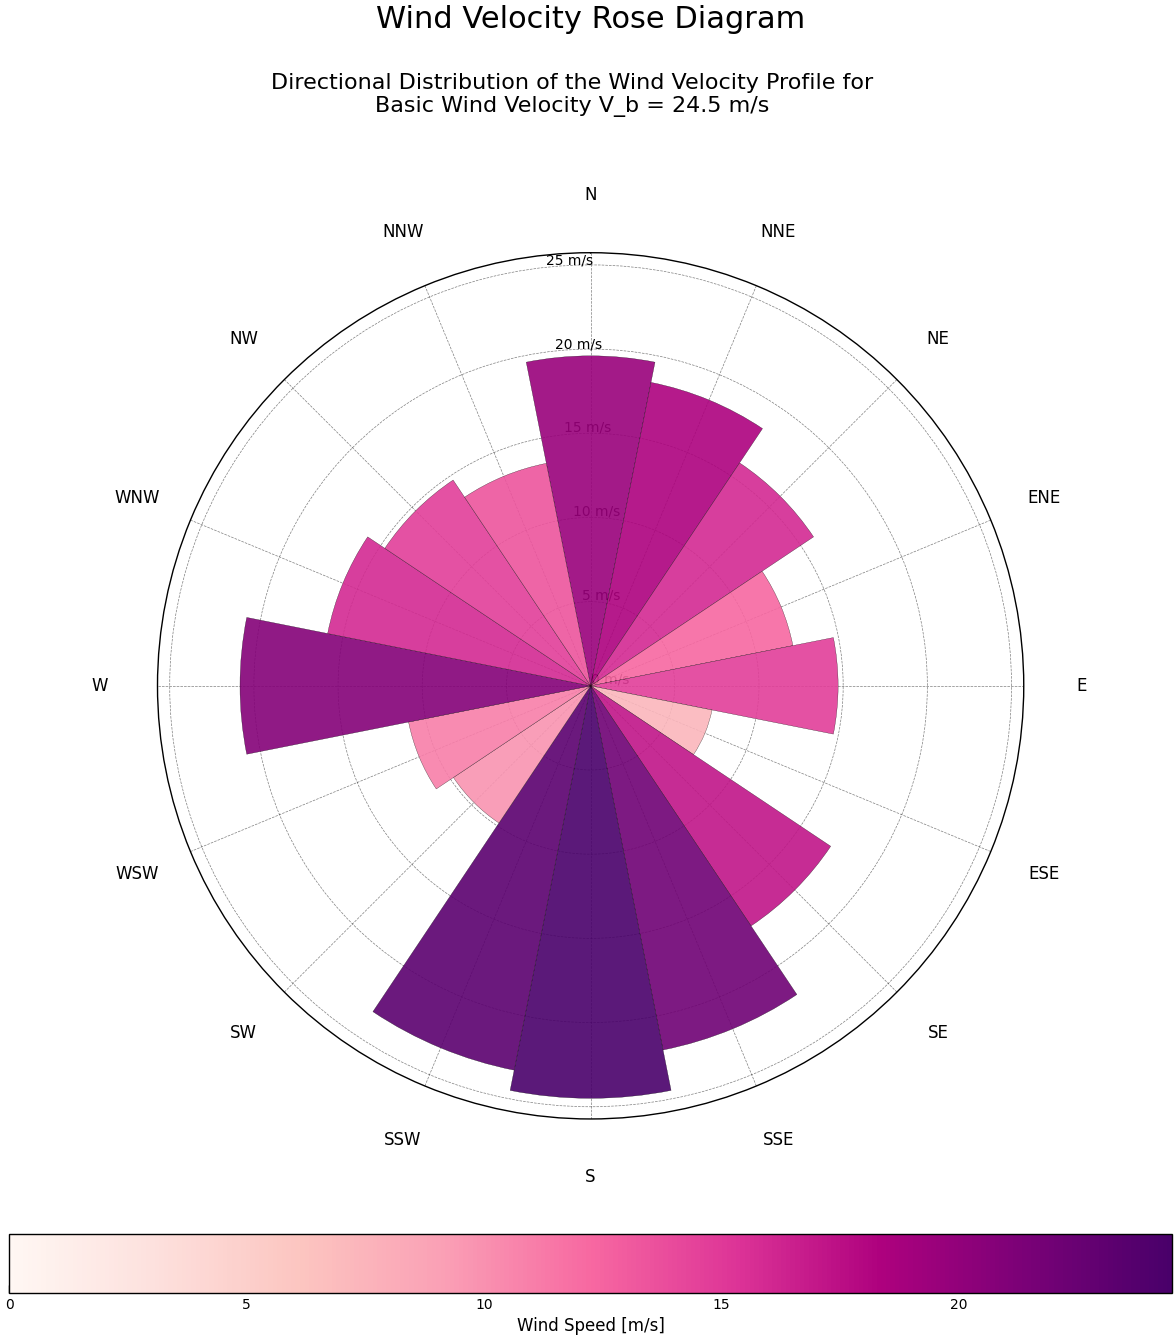

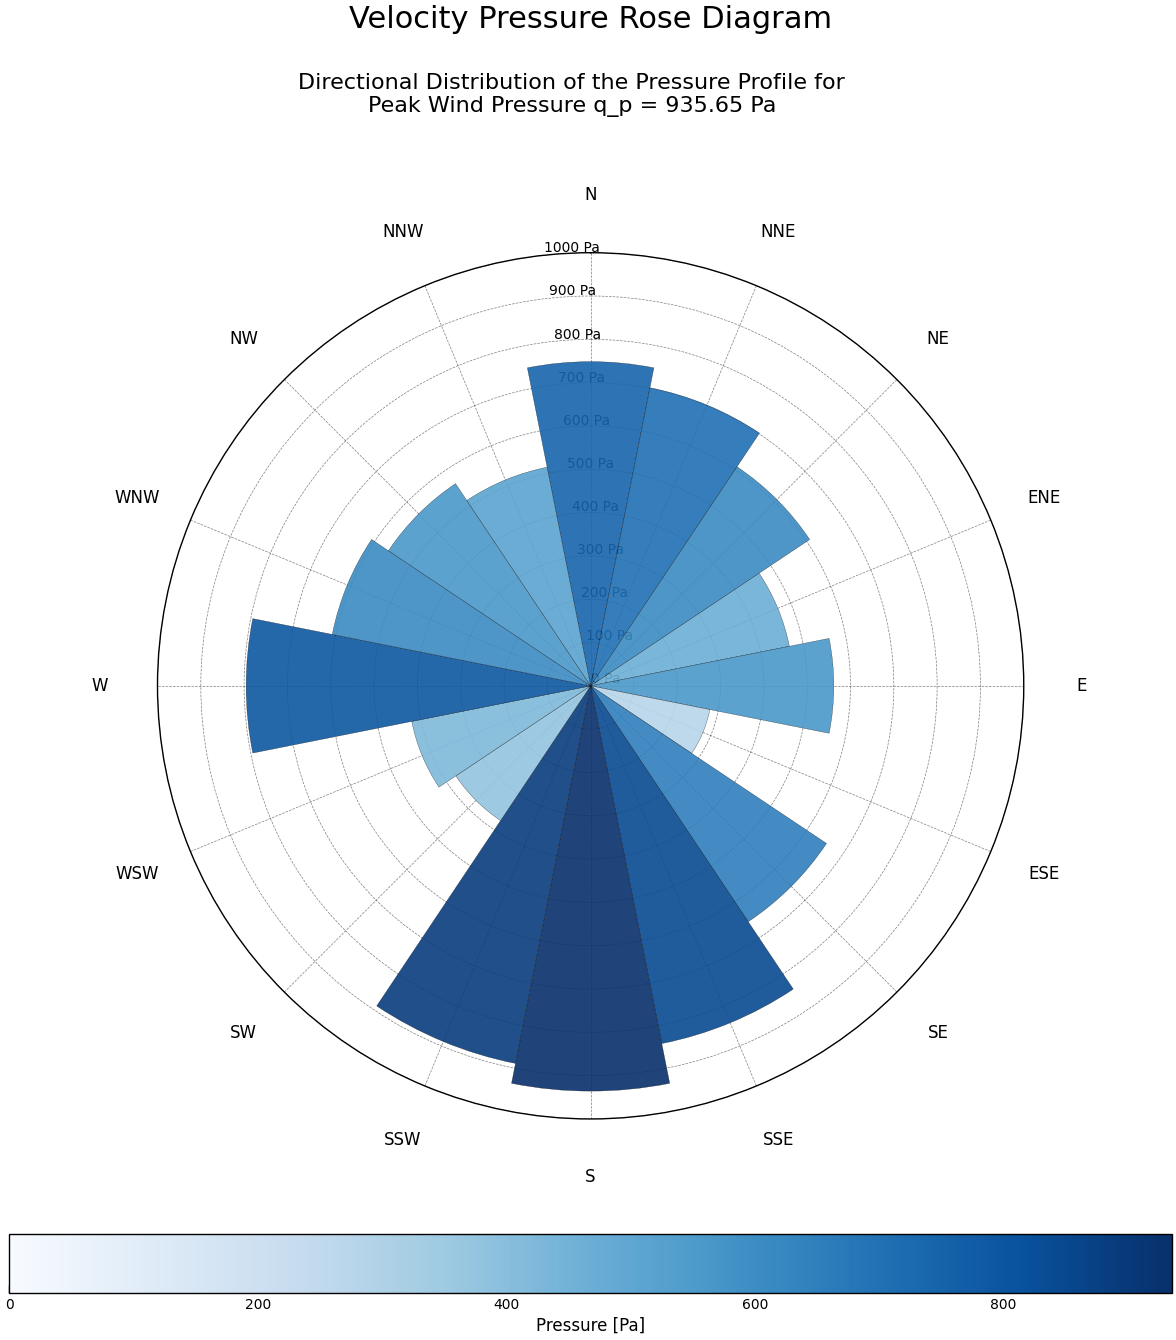

In [19]:
# Layout ("P", "L")
# Unit ("mm", "cm", "in")
# format ("A3", "A4" (default), "A5", "Letter", "Legal", (100, 150))

title = "EXAMPLE Solar Farm Wind Loading Report"

# --------------------------------------------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------------------------------------------

class PDF(fpdf.FPDF):
    def __init__(self, orientation='P', unit='mm', format='A4'):
        super().__init__(orientation, unit, format)
        self.set_left_margin(25)
        self.set_right_margin(25)
        self.toc = []
        
    def header(self):
        if self.page == 1:
            self.set_font("helvetica", "", 18)
            self.title_w = self.get_string_width(title) + 6
            self.cell(self.title_w, 10, title, border=False, align="L", fill=0)
            self.ln(10)
            self.set_font("helvetica", "", 14)
            self.cell(self.title_w, 10, "MEng/CEng Mihail Todorov", border=False, align="L", fill=0)
            self.ln(7.5)
            self.set_font("helvetica", "", 12)
            self.cell(self.title_w, 10, "Structural Design ltd.", border=False, align="L", fill=0)
            self.ln(15)
            self.image("solar_image.jpg", x=(self.w - 210) / 2, y=self.get_y(), w=210)
            self.image("wind_image.jpg", x=(self.w - 210) / 2, y=self.get_y() + 80, w=210)
            self.ln(130)
    
    def footer(self):
        self.set_y(-15)
        self.set_font("helvetica", "", 10)
        self.set_text_color(0, 0, 0)
        self.cell(0, 10, f"Page {self.page_no()}/{{nb}}", align="C")

    def add_section(self, title, content=None, file_path=None):
        self.add_page()
        self.section_title = title
        self.toc.append((title, self.page_no()))
        self.ln(10)
        self.set_font("helvetica", "B", 12)
        self.cell(0, 10, title, border=False, ln=True)
        self.ln(15)
        self.set_font("helvetica", "", 12)

        if file_path:
            with open(file_path, "r") as file:
                content = file.read()
                
            self.multi_cell(0, 10, content)
            self.ln(5)

        elif content:
            if isinstance(content, dict):
                for label, value in content.items():
                    self.cell(100, 10, label, border=False)
                    self.cell(0, 10, f"{value}", border=False, ln=True, align='R')
                self.ln(5)
            elif isinstance(content, str):
                self.multi_cell(0, 10, content)
                self.ln(5)
            elif isinstance(content, tuple):
                description, values = content
                self.multi_cell(0, 10, description)
                self.ln(5)
                for label, value in values.items():
                    self.cell(100, 10, label, border=False)
                    self.cell(0, 10, f"{value}", border=False, ln=True, align='R')
                self.ln(5)

# --------------------------------------------------------------------------------------------------------------------------------

def get_user_input():
    H = float(input("Enter the Building Height (H) in meters: "))
    L = float(input("Enter the Building Length (L) in meters: "))
    W = float(input("Enter the Building Width (W) in meters: "))
    z = float(input("Enter the Height above Ground (h) in meters: "))
    L_distance_shore = float(input("Enter the Distance from Building to Shoreline (L_distance_shore) in meters: "))
    A_altitude = float(input("Enter the Altitude above Sea Level (A_altitude) in meters: "))
    V_b_map_wind_velocity = float(input("Enter the Basic Wind Velocity (V_b_map_wind_velocity) in m/s: "))
    c_dir_factor = float(input("Enter the Directional Factor (c_dir_factor): "))
    c_season_factor = float(input("Enter the Season Factor (c_season_factor): "))
    K_shape_parameter = float(input("Enter the Shape Parameter (K_shape_parameter): "))
    n_exponent = float(input("Enter the Exponent (n_exponent): "))
    p_air_density = float(input("Enter the Air Density (p_air_density) in kg/m^3: "))
    p_probability_of_annual_exceedance = float(input("Enter the Probability of Annual Exceedance (p_probability_of_annual_exceedance): "))

    
# --------------------------------------------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------------------------------------------

class WindLoadDesign:
    def __init__(self, project_name, H, L, W, z, terrain_category, L_distance_shore, A_altitude, V_b_map_wind_velocity, c_dir_factor, c_season_factor, K_shape_parameter, n_exponent,
                 p_air_density, p_probability_of_annual_exceedance, directional_wind_velocity_profile, c_o_orograhpy = 1):
        
        #The name of the Project
        self.project_name = project_name
        
        # Structure Specific Components for the calculation of Wind Pressure and Loading
        self.H = H  # Height of the building
        self.L = L  # Length of the building
        self.W = W  # Width of the building
        self.z = z  # Height above the ground level at which the wind speed is required
        
        self.terrain_category = terrain_category # Determining the terrain category
        self.L_distance_shore = L_distance_shore  # Distance from the building location to the shoreline
        self.A_altitude = A_altitude  # Altitude above sea level at the building location
        self.V_b_map_wind_velocity = V_b_map_wind_velocity  # Basic wind velocity at the building location
        
        self.c_dir_factor = c_dir_factor  # Directional factor
        self.c_season_factor = c_season_factor  # Season factor
        
        self.K_shape_parameter = K_shape_parameter  # Shape parameter for the building
        self.n_exponent = n_exponent  # Exponent for the building shape
        
        self.p_air_density = p_air_density  # Air density
        self.p_probability_of_annual_exceedance = p_probability_of_annual_exceedance  # Probability of annual exceedance
        
        # Rose Diagram Proportion Component
        self.directional_wind_velocity_profile = directional_wind_velocity_profile
        self.c_o_orograhpy = c_o_orograhpy
        
        self.turbulence_regressor = TurbulenceRegressor()
        self.turbulence_regressor.load_model('turbulence_regressor.pkl')
        
        self.calculate_additional_values()

# --------------------------------------------------------------------------------------------------------------------------------    
    def calculate_turbulence_intensity(self):
        X_new = np.array([[self.z, self.L_distance_shore]])
        return self.turbulence_regressor.predict(X_new)[0]
    
    
    def calculate_exposure_factor_c_e(self, z, terrain_category):
        # Define the parameters based on the terrain category
        terrain_parameters = {
            '0': {'z_0': 0.0002, 'alpha': 0.07, "z_min" : 1},
            'I': {'z_0': 0.003, 'alpha': 0.10, "z_min" : 1},
            'II': {'z_0': 0.01, 'alpha': 0.15, "z_min" : 2},
            'III': {'z_0': 0.05, 'alpha': 0.20, "z_min" : 5},
            'IV': {'z_0': 0.30, 'alpha': 0.30, "z_min" : 10},
        }
        
        if terrain_category not in terrain_parameters:
            raise ValueError("Invalid terrain category. Choose from '0', I', 'II', 'III', or 'IV'.")
        
        z_0 = terrain_parameters[terrain_category]['z_0']
        alpha = terrain_parameters[terrain_category]['alpha']
        
        # Terrain category II is used as the standard reference category, this is why z_0 is always divided by 0.05 to normalize the effect relative to the reference
        self.k_r_terrain_factor = 0.19*((z_0/0.05)**0.07)
        self.c_r_roughness_factor = self.k_r_terrain_factor * math.log(z / z_0)

        return self.c_r_roughness_factor
    

    def calculate_additional_values(self):
        self.A_ref_area = self.L * self.W * math.sin(math.radians(55))
        self.A_uplift_area = self.L * self.W * math.cos(math.radians(55))
        
        # Altitute correction factor can be conservatively considered as 0.6*z
        self.c_alt_factor = self.A_altitude * 0.001 + 1
        self.v_b_0_fundamental_wind_velocity = self.c_alt_factor * self.V_b_map_wind_velocity
        self.c_prob_factor = ((1 - self.K_shape_parameter * np.log(-np.log(1 - self.p_probability_of_annual_exceedance))) /
                              (1 - self.K_shape_parameter * (np.log(-np.log(0.98))))) ** self.n_exponent
        self.c_e_exposure_factor = self.calculate_exposure_factor_c_e(self.z, self.terrain_category)
        
        self.v_b_basic_wind_velocity = (self.c_dir_factor * self.c_season_factor *
                                         self.v_b_0_fundamental_wind_velocity * self.c_prob_factor)
        
        self.v_m_mean_wind_velocity = self.c_r_roughness_factor * self.c_o_orograhpy * self.v_b_basic_wind_velocity
        
        self.q_b_reference_mean_velocity_pressure = 0.5 * self.p_air_density * (self.v_b_basic_wind_velocity ** 2)
        
        self.lv_turbulence_factor = self.calculate_turbulence_intensity()
        
                                                                                
        self.q_p_peak_velocity_pressure = max(self.q_b_reference_mean_velocity_pressure * self.c_e_exposure_factor, ((1 + 3*self.lv_turbulence_factor/ self.c_o_orograhpy))
                                              * 1/2 * self.p_air_density * (self.v_m_mean_wind_velocity ** 2))
        
        # self.q_p_peak_velocity_pressure = ((1 + 3*self.lv_turbulence_factor/ self.c_o_orograhpy)**2) * 0.5 * self.p_air_density * (self.v_m_mean_wind_velocity ** 2)
        
        
        
        
        self.F_wind_total_wind_force = self.c_season_factor * self.c_dir_factor * self.q_p_peak_velocity_pressure
        
         # Calculate additional values for bending moment, uplift, and shear
        self.V_total_shear_force = self.F_wind_total_wind_force * self.A_ref_area
        self.M_total_bending_moment = self.z/2 * self.V_total_shear_force
        self.U_total_uplift = self.F_wind_total_wind_force * self.A_uplift_area

# --------------------------------------------------------------------------------------------------------------------------------

    def print_results(self):
        
        print("WIND LOAD DESIGN RESULTS")
        print(f"------------------------------")
        print()
        
        # Geometry
        print(f"------------------------------")
        print("Geometry")
        print(f"------------------------------")
        print("{:<80} {:>10}".format("Structure Height (H):", f"{self.H} m"))
        print("{:<80} {:>10}".format("Structure Length (L):", f"{self.L} m"))
        print("{:<80} {:>10}".format("Structure Width (W):", f"{self.W} m"))
        print("{:<80} {:>10}".format("Height above Ground (z):", f"{self.z} m"))
        
        print()
        # Site Specific Factors
        print(f"------------------------------")
        print("Site Specific Factors")
        print(f"------------------------------")
        print("{:<80} {:>10}".format("Distance from Building to Shoreline (L_distance_shore):", f"{self.L_distance_shore} km"))
        print("{:<80} {:>10}".format("Altitude above Sea Level (A_altitude):", f"{self.A_altitude} m"))
        print("{:<80} {:>10}".format("MAP Wind Velocity (V_b_map_wind_velocity):", f"{self.V_b_map_wind_velocity} m/s"))
        print("{:<80} {:>10}".format("Directional Factor (c_dir_factor):", self.c_dir_factor))
        print("{:<80} {:>10}".format("Season Factor (c_season_factor):", self.c_season_factor))
        print("{:<80} {:>10}".format("Shape Parameter (K_shape_parameter):", self.K_shape_parameter))
        print("{:<80} {:>10}".format("Exponent (n_exponent):", self.n_exponent))
        print("{:<80} {:>10}".format("Air Density (p_air_density):", f"{self.p_air_density} kg/m^3"))
        print("{:<80} {:>10}".format("Probability of Annual Exceedance (p_probability_of_annual_exceedance):", self.p_probability_of_annual_exceedance))
        print("{:<80} {:>10}".format("Altitude Factor (c_alt_factor):", f"{self.c_alt_factor}"))
        print("{:<80} {:>10}".format("Turbulence Factor (lv_turbulence_factor):", f"{self.lv_turbulence_factor}"))
        
        print()
        # Velocity and Pressure Profile
        print(f"------------------------------")
        print("Velocity and Pressure Profile")
        print(f"------------------------------")
        print("{:<80} {:>10}".format("Fundamental Wind Velocity (V_b_0):", f"{self.v_b_0_fundamental_wind_velocity:.2f} m/s"))
        print("{:<80} {:>10}".format("Probability Factor (c_prob_factor):", f"{self.c_prob_factor:.2f}"))
        print("{:<80} {:>10}".format("Basic Wind Velocity (V_b):", f"{self.v_b_basic_wind_velocity:.2f} m/s"))
        print("{:<80} {:>10}".format("Mean Wind Velocity (V_m):", f"{self.v_m_mean_wind_velocity:.2f} m/s"))
        print("{:<80} {:>10}".format("Exposure Coefficient (c_e)", f"{self.c_e_exposure_factor:.2f}"))
        print("{:<80} {:>10}".format("Reference Mean Velocity Pressure (q_b):", f"{self.q_b_reference_mean_velocity_pressure:.2f} N/m^2"))
        print("{:<80} {:>10}".format("Peak Velocity Pressure (q_p):", f"{self.q_p_peak_velocity_pressure:.2f} N/m^2"))
        print("{:<80} {:>10}".format("Total Wind Force per unit area (F_total):", f"{self.F_wind_total_wind_force:.2f} N/m^2"))
        
        print()
        # Velocity and Pressure Profile
        print(f"------------------------------")
        print("Static Loading")
        print(f"------------------------------")
        print("{:<80} {:>10}".format("Total Shear Force on the Structure:", f"{self.V_total_shear_force:.2f} N"))
        print("{:<80} {:>10}".format("Total Bending Moment on the Structure:", f"{self.M_total_bending_moment:.2f} Nm"))
        print("{:<80} {:>10}".format("Total Uplift on the Structure:", f"{self.U_total_uplift:.2f} N"))

# --------------------------------------------------------------------------------------------------------------------------------

    def generate_conclusion(self):
        conclusion_text = (
                f"This report provides a comprehensive analysis of the wind loading on the {self.project_name} Solar Farm. "
                f"Based on the principles and guidelines of Eurocode 0 (EN 1990) and Eurocode 1 (EN 1991-1-4), "
                f"the following important values have been derived:\n\n"
                f"1. Reference Mean Velocity Pressure (q_b): {self.q_b_reference_mean_velocity_pressure:.2f} N/m²\n"
                f"2. Peak Velocity Pressure (q_p): {self.q_p_peak_velocity_pressure:.2f} N/m²\n"
                f"3. Total Wind Force per unit area (F_total): {self.F_wind_total_wind_force:.2f} N/m²\n\n"
                "These values provide a robust basis for assessing the structural integrity and safety of the solar farm under wind loading conditions. "
                "By adhering to the Eurocode standards, this analysis ensures compliance with European structural design requirements, "
                f"guaranteeing the reliability and resilience of the {self.project_name} Solar PV Farm against wind actions."
            )
        
        return conclusion_text
        
# --------------------------------------------------------------------------------------------------------------------------------

    def generate_wind_loading_report(self):
        self.pdf = PDF("P", "mm", format="A4")
        self.pdf.alias_nb_pages()
        self.pdf.set_auto_page_break(auto=1, margin=15)

        def add_table_of_contents():
            self.pdf.set_font("helvetica", "B", 16)
            self.pdf.cell(0, 10, "Table of Contents", align='C')
            self.pdf.ln(10)
            self.pdf.set_font("helvetica", "", 12)
            for i, (title, page) in enumerate(self.pdf.toc, start=1):
                self.pdf.cell(0, 10, f"{i}. {title}", border=False)
                self.pdf.set_x(-30)
                self.pdf.cell(0, 10, f"{page}", border=False)
                self.pdf.ln(5)


        # Add the first page with header and images
        self.pdf.add_page()
        self.pdf.set_font("helvetica", size=12)
        self.pdf.ln(130)  # Adjust this value to ensure text starts after the images

        # Add a blank TOC page
        self.pdf.add_page()
        toc_page = self.pdf.page_no()

    # --------------------------------------------------------------------------------------------------------------------------------
    
        # Collect content
        scope_description = (
            f"The Wind Loading Design Report provides a comprehensive analysis of the wind loading on the {self.project_name} Solar Farm, including considerations of various"
            "site specific factors and parameters . The analysis includes detailed calculations and assessments of wind velocity, pressure distributions,"
            "and the resulting forces on the structure. The purpose of this report is to ensure the structural integrity and safety of the solar farm under various wind conditions."
            "The methodologies and results presented herein follow industry standards and are based on the latest available data and engineering principles. When required the design"
            "considerations use appropriate assumptions as part of the process allowed under the applicable normative framework, if not stated otherwise the most conservative"
            "approach is always implemented. The particular Design Standards used for the calculation and verification of applied loadings are detailed below.\n"
            "\n"
            "Design Standards and Guidelines:\n"
            "\n"
            "1. Eurocode 0: Basis of Structural Design (EN 1990);\n"
            "2. Eurocode 1: Actions on Structures - Part 1-4: General Actions - Wind Actions (EN 1991-1-4);\n"
            "3. BS EN 1991-1-4:2005 + A1:2010;"
        )
        
        geometry_description = (
            "The effect of the wind on the structure (i.e. the response of the structure), depends on the size, shape and dynamic properties of the structure."
            "The Wind Loading Design Report is reliant on the definition of two lines of technical information - overall structural parameters, "
            "described in the Geometry section of the report and the overall wind velocity and pressure profile, dependent on the site specific conditions. "
            "For the purposes of this Wind Loading Design Report, to calculate the forces and moments acting upon the structure, the first step is to define "
            "the geometry on which wind loading actions apply. For the purposes of this report the geometry of the PV module structure can be described as a "
            "simple parallelogram, defined by the following key characteristics:\n"
            "\n"
        )

        geometry = {
            "Structure Height (H):": f"{self.H} [m]",
            "Structure Length (L):": f"{self.L} [m]",
            "Structure Width (W):": f"{self.W} [m]",
            "Height above Ground (z):": f"{self.z} [m]"
        }

        site_factors_description = (
            "The Site-Specific Factors are the parameters of the engineering design related to the environment's global and local geography, "
            "topology, features and patterns of the terrain that shape the movement of wind masses in the vicinity of the site as well as the probability "
            "and statistical significance of events caused by said factors. These factors, similar to the geometry, are very much site specific, capturing the "
            "individual intricacies of each project and surrounding environment. Most of the coefficients and values are taken at face value and do not require much"
            "consideration outside of the context of the site and the design process. The values provided in this section are derived intrinsically and are not reliant"
            "on complex modelling or calculation procedures.\n"
            "\n"
            "Detailed descriptions and derivations for those factors and their respective values "
            "exist in Europe as part of National Annexes and are further explained in the context of the design by Eurocode 1: Actions on Structures - Part 1-4: "
            "General Actions - Wind Actions (EN1991-1-4), but are also briefly summarized in the report.\n"
            "\n"
        )

        site_factors = {
            "Distance from Building to Shoreline (L_distance_shore):": f"{self.L_distance_shore} [km]",
            "Altitude above Sea Level (A_altitude):": f"{self.A_altitude} [m]",
            "Altitude Factor (c_alt_factor):": f"{self.c_alt_factor}",
            "MAP Wind Velocity (V_b_map_wind_velocity):": f"{self.V_b_map_wind_velocity} [m/s]",
            "Directional Factor (c_dir_factor):": self.c_dir_factor,
            "Season Factor (c_season_factor):": self.c_season_factor,
            "Shape Parameter (K_shape_parameter):": self.K_shape_parameter,
            "Air Density (p_air_density):": f"{self.p_air_density} [kg/m^3]",
            "Exponent (n_exponent):": self.n_exponent,
            "Probability of Annual Exceedance (p_probability_of_annual_exceedance):": self.p_probability_of_annual_exceedance,

        }

        velocity_pressure_profile_description = (
            "The Velocity and Pressure Profile section of the Wind Design Report provides the wind loading results associated with the properties of both the structure and "
            "the environment surrounding the site. The Velocity and Pressure Profile gives detailed information about the particular loading wind masses will exert on any structure "
            "in the vicinity of the site and in particular to those of similar structural composition as the PV Module Farm. To further emphasize the probabilistic design nature of wind loading design "
            "and assist further structural considerations, the Wind Loading Design Report provides a detailed Wind Rose Diagram associated with wind velocities across all 16 directions, developed assuming "
            "the calculated basic wind velocity and applying multiplication factors in each direction, dependent on directional wind patterns on the site."
            "The coefficients, factors, and site parameters presented here are mostly derived or modelled on previously established intrinsic characteristics of the site and its design."
            "Eurocode and the national annexes in various countries including the British Standard have provisions for derivation or modelling of the velocity-pressure profile parameters, "
            "however certain factors and coefficients are empirically obtained or derived from semi or quasi empirical datasets transformed into graphs, in those cases the graphs provided "
            "were transformed into data to train Linear Regression models to allow for the generalization of design parameters based on the known (intrinsic) ones (further information on"
            "the particular ML algorithms, training, verification and testing datasets can be presented as supplemented material on request.\n"
            "\n"
        )

        velocity_pressure_profile = {
            "Fundamental Wind Velocity (V_b_0):": f"{self.v_b_0_fundamental_wind_velocity:.2f} [m/s]",
            "Basic Wind Velocity (V_b):": f"{self.v_b_basic_wind_velocity:.2f} [m/s]",
            "Mean Wind Velocity (V_m):": f"{self.v_m_mean_wind_velocity:.2f} [m/s]",
            "Exposure Coefficient (c_e)": f"{self.c_e_exposure_factor:.2f}",
            "Orography Coefficient (c_o_orograhpy):": f"{self.c_o_orograhpy:.2f}",
            "Probability Factor (c_prob_factor):": f"{self.c_prob_factor:.2f}",
            "Terrain Factor (k_r_terrain_factor):": f"{self.k_r_terrain_factor:.2f}",
            "Rougness Factor (c_r_roughness_factor):": f"{self.c_r_roughness_factor:.2f}",
            "Turbulence Factor (lv_turbulence_factor):": f"{self.lv_turbulence_factor:.2f}",
            "Reference Mean Velocity Pressure (q_b):": f"{self.q_b_reference_mean_velocity_pressure:.2f} [N/m^2]",
            "Peak Velocity Pressure (q_p):": f"{self.q_p_peak_velocity_pressure:.2f} [N/m^2]",
            "Total Wind Force per unit area (F_total):": f"{self.F_wind_total_wind_force:.2f} [N/m^2]"
        }

        static_loading = {
            "Total Shear Force on the Structure:": f"{self.V_total_shear_force:.2f} [N]",
            "Total Bending Moment on the Structure:": f"{self.M_total_bending_moment:.2f} [Nm]",
            "Total Uplift on the Structure:": f"{self.U_total_uplift:.2f} [N]"
        }

# --------------------------------------------------------------------------------------------------------------------------------

        # Ensure each section is added only once
        self.pdf.add_section("Scope", content=scope_description)
        
        # Combine the description and geometry values in the same section
        self.pdf.add_section("Geometry", content=(geometry_description, geometry))
        
        self.pdf.add_section("Site Specific Factors", content=(site_factors_description, site_factors))
        self.pdf.add_section("Velocity and Pressure Profile", content=(velocity_pressure_profile_description, velocity_pressure_profile))
        self.pdf.add_section("Static Loading", content=static_loading)
        
        
        # Wind Rose Diagram Section
        wind_rose = WindRoseDiagram(self.V_b_map_wind_velocity, self.directional_wind_velocity_profile)
        wind_rose.generate_wind_rose()
        
        self.pdf.add_section("Wind Velocity Rose Diagram", content="This section provides the wind rose diagram indicating the directional distribution of wind velocity based on the given profile."
                             "The sixteen general directions indicated within the context of the drawing have their associatedwind velocity profile.")
        
        self.pdf.image('Wind_Rose_Diagram.png', x=25, y=None, w=160)
        
        
        #Pressure Rose Diagram Section
        pressure_rose = PressureRoseDiagram(self.q_p_peak_velocity_pressure, self.directional_wind_velocity_profile)
        pressure_rose.generate_pressure_rose()
        
        self.pdf.add_section("Velocity Pressure Rose Diagram", content="This section provides the pressure rose diagram indicating the directional distribution of wind velocity pressure"
                             "based on the given profile.")
        
        self.pdf.image('Pressure_Rose_Diagram.png', x=25, y=None, w=160)

        
        # Generate and add the conclusion section dynamically
        conclusion_text = self.generate_conclusion()
        self.pdf.add_section("Conclusions", content=conclusion_text)

        # Save the current page number
        current_page = self.pdf.page_no()

        # Go back to the TOC page and fill it
        self.pdf.page = toc_page
        self.pdf.set_auto_page_break(auto=0)
        add_table_of_contents()
        self.pdf.set_auto_page_break(auto=1, margin=15)

        # Restore to the last page after TOC
        self.pdf.page = current_page

        self.pdf.output(f"{self.project_name}_Wind_Loading_Report_R01.pdf")

# --------------------------------------------------------------------------------------------------------------------------------

# User Input usage:
# get_user_input()

# --------------------------------------------------------------------------------------------------------------------------------

# Example usage:
flat_roof = WindLoadDesign(
    project_name = "EXAMPLE NAME",
    H=4, L=3.313, W=4, z=5, terrain_category = "I", L_distance_shore=30, A_altitude=115, V_b_map_wind_velocity=24.5,
    c_dir_factor=1.0, c_season_factor=1.0, K_shape_parameter=0.2, n_exponent=0.2, p_air_density=1.226,
    p_probability_of_annual_exceedance=0.01,
    directional_wind_velocity_profile = [0.8, 0.75, 0.65, 0.5, 0.6, 0.3, 0.7, 0.9, 1, 0.95, 0.4, 0.45, 0.85, 0.65, 0.6, 0.55]
)

# --------------------------------------------------------------------------------------------------------------------------------

flat_roof.calculate_additional_values()
flat_roof.print_results()
flat_roof.generate_wind_loading_report()